# K-Means Clustering — From Scratch (1D → 2D) + scikit-learn

**What you'll learn (fast):**
1. Implement K-Means *from scratch* (no built-in k-means) in **1D** and **2D**
2. See **centroids move** each iteration (visual + numbers)
3. Understand **SSE (inertia)** and why it always decreases
4. See how **initialization** can help/hurt
5. Choose **K** using **Elbow** (SSE vs K) and **Silhouette**
6. Validate with **`sklearn.cluster.KMeans`**

---


## 0) Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

### Core math
**Squared Euclidean distance** (avoids square-roots; nearest centroid is unchanged):
$$d^2(x,\mu)=\sum_j (x_j-\mu_j)^2$$

**SSE / inertia** (what K-Means minimizes):
$$\text{SSE}=\sum_{k=1}^{K}\sum_{x\in C_k}\|x-\mu_k\|^2$$


### Helper functions (provided) — not limited to 3 lines

In [2]:
def sqdist(X, c):
    """Squared distance from each row of X to centroid c."""
    return np.sum((X - c)**2, axis=1)

def assign_labels(X, C):
    """Assign each point to nearest centroid (by squared distance)."""
    d2 = np.stack([sqdist(X, C[k]) for k in range(len(C))], axis=1)
    return np.argmin(d2, axis=1)

def update_centroids(X, labels, C):
    """Update each centroid = mean of points in its cluster (keep if empty)."""
    newC = [] # New Centroid array
    for k in range(len(C)):
        pts = X[labels == k]
        newC.append(pts.mean(axis=0) if len(pts) else C[k])
    return np.array(newC, dtype=float)

def compute_sse(X, labels, C):
    """SSE = sum of squared distances to assigned centroid."""
    total = 0.0
    for k in range(len(C)):
        pts = X[labels == k]
        if len(pts):
            total += sqdist(pts, C[k]).sum()
    return float(total)

def run_kmeans_history(X, C0, max_iter=50):
    """Run K-Means and record (labels, centroids, sse) per iteration."""
    C = C0.astype(float).copy()
    hist = []
    for _ in range(max_iter):
        labels = assign_labels(X, C)
        s = compute_sse(X, labels, C)
        hist.append((labels.copy(), C.copy(), s))
        newC = update_centroids(X, labels, C)
        if np.allclose(newC, C):
            break
        C = newC
    return hist, C


## 1) K-Means in 1D (from scratch)

Dataset:
$$X=[2,4,6,8,9]$$

We reshape to `(n,1)` so the same code works for 1D and 2D.


In [3]:
X1 = np.array([2,4,6,8,9], dtype=float).reshape(-1,1)
X1[:3].ravel()
X1.shape

(5, 1)

### Choose K=2 and initialize centroids (simple pick from data)

In [27]:
C0_1 = np.array([[0.0],[1.0]])
hist1, C1 = run_kmeans_history(X1, C0_1)
C1.ravel()

array([3.        , 7.66666667])

### Print iteration summary (centroids + SSE)

In [28]:
for t,(lab,C,s) in enumerate(hist1):
    print(f"iter={t:02d}  C={C.ravel()}  SSE={s:.4f}")

iter=00  C=[0. 1.]  SSE=148.0000
iter=01  C=[0.  5.8]  SSE=22.3600
iter=02  C=[2.   6.75]  SSE=11.1875
iter=03  C=[3.         7.66666667]  SSE=6.6667


### Plot: 1D centroid movement (iteration by iteration)
- Dots: data points  
- X markers: centroids at each iteration


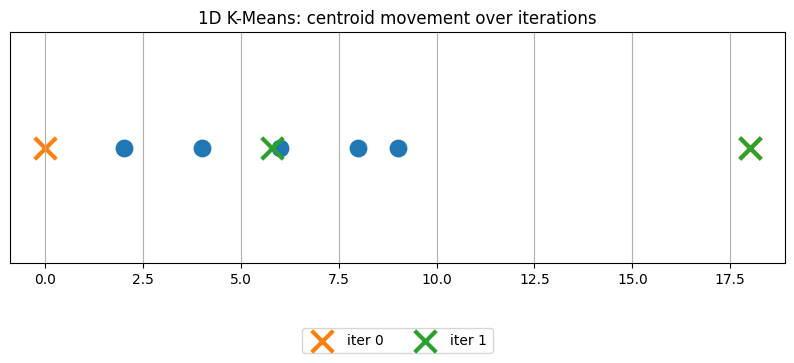

In [6]:
xs = X1.ravel()
plt.figure(figsize=(10,3))
plt.scatter(xs, np.zeros_like(xs), s=140)
for t,(_,C,_) in enumerate(hist1):
    plt.scatter(C.ravel(), np.zeros(len(C)), marker='x', s=240, linewidths=3, label=f'iter {t}')
plt.yticks([])
plt.title('1D K-Means: centroid movement over iterations')
plt.legend(ncol=4, bbox_to_anchor=(0.5,-0.25), loc='upper center')
plt.grid(True, axis='x')
plt.show()

### What happened (1D)
- **Assign:** each number goes to its nearest centroid
- **Update:** each centroid becomes the **mean** of its assigned numbers
- **SSE decreases** until convergence (centroids stop changing)


## 2) K-Means in 2D (from scratch)

Dataset (your points):
$$ (0,1),(1,2),(2,2),(3,4),(4,3),(4,4) $$


In [7]:
X2 = np.array([(0,1),(1,2),(2,2),(3,4),(4,3),(4,4)], dtype=float)
X2
X2.shape

(6, 2)

### Run K=2 with a **good initialization** (far apart): (0,1) and (4,4)

In [8]:
C0_good = np.array([[0,1],[4,4]], dtype=float)
h_good, C_good = run_kmeans_history(X2, C0_good)
C_good

array([[1.        , 1.66666667],
       [3.66666667, 3.66666667]])

### Iteration summary (centroids + SSE)

In [9]:
for t,(lab,C,s) in enumerate(h_good):
    print(f"iter={t:02d}  C={C}  SSE={s:.4f}")

iter=00  C=[[0. 1.]
 [4. 4.]]  SSE=9.0000
iter=01  C=[[1.         1.66666667]
 [3.66666667 3.66666667]]  SSE=4.0000


### Plot: centroid paths in 2D (good init)
We draw the centroid positions across iterations to show movement.


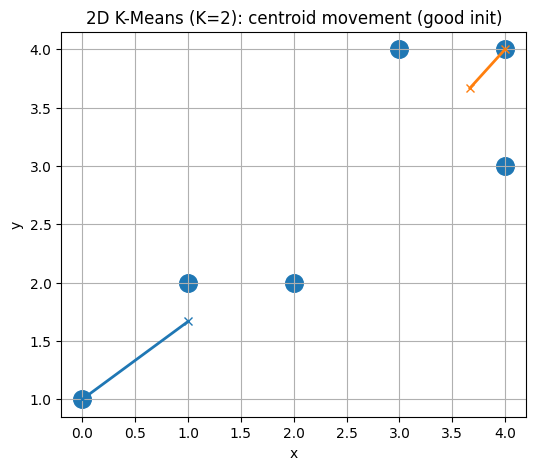

In [10]:
plt.figure(figsize=(6,5))
plt.scatter(X2[:,0], X2[:,1], s=160)
K = len(h_good[0][1])
for k in range(K):
    path = np.array([C[k] for (_,C,_) in h_good])
    plt.plot(path[:,0], path[:,1], marker='x', linewidth=2)
plt.title('2D K-Means (K=2): centroid movement (good init)')
plt.xlabel('x'); plt.ylabel('y'); plt.grid(True)
plt.show()

## 3) Initialization impact (good vs bad)

K-Means can converge to different **paths** (and sometimes different final solutions) depending on start.

We compare:
- **Good init:** (0,1) & (4,4)  (far apart)
- **Bad/close init:** (0,1) & (1,2)  (too close)


### Bad/close initialization

In [11]:
C0_bad = np.array([[0,1],[1,2]], dtype=float)
h_bad, C_bad = run_kmeans_history(X2, C0_bad)
C_bad


array([[1.        , 1.66666667],
       [3.66666667, 3.66666667]])

### Compare SSE trajectories (should be non-increasing)

In [12]:
s_good = [s for (_,_,s) in h_good]
s_bad  = [s for (_,_,s) in h_bad]
(s_good, s_bad)


([9.0, 4.0], [32.0, 8.56, 5.875, 4.0])

### Plot: SSE vs iteration (good vs bad init)

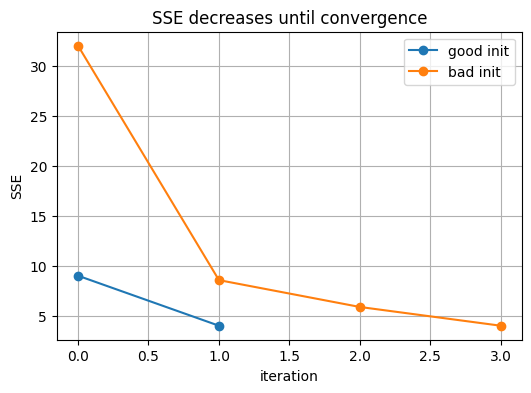

In [13]:
plt.figure(figsize=(6,4))
plt.plot(s_good, marker='o', label='good init')
plt.plot(s_bad, marker='o', label='bad init')
plt.xlabel('iteration'); plt.ylabel('SSE')
plt.title('SSE decreases until convergence')
plt.grid(True); plt.legend()
plt.show()


### Plot: centroid paths (good vs bad init)

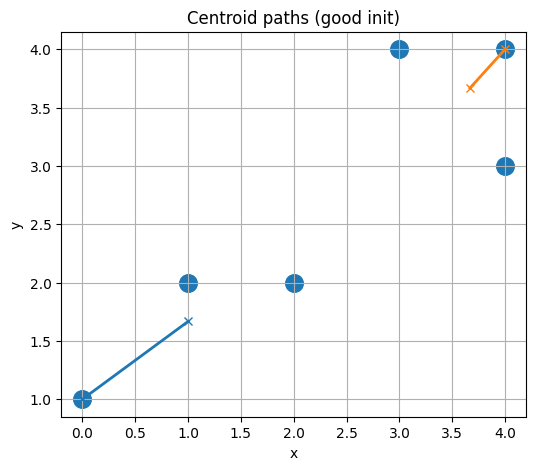

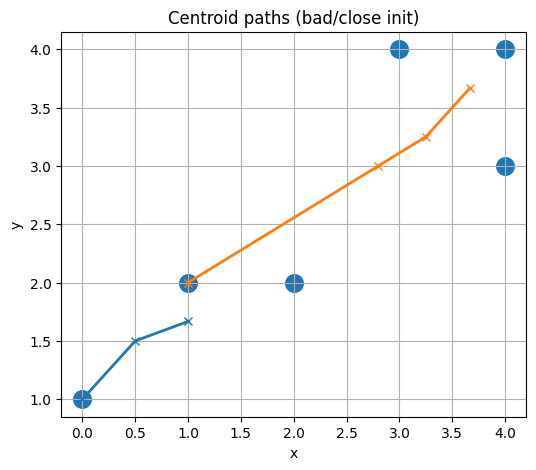

In [14]:
def plot_paths(hist, title):
    plt.figure(figsize=(6,5))
    plt.scatter(X2[:,0], X2[:,1], s=160)
    K = len(hist[0][1])
    for k in range(K):
        path = np.array([C[k] for (_,C,_) in hist])
        plt.plot(path[:,0], path[:,1], marker='x', linewidth=2)
    plt.title(title); plt.xlabel('x'); plt.ylabel('y'); plt.grid(True); plt.show()

plot_paths(h_good, 'Centroid paths (good init)')
plot_paths(h_bad,  'Centroid paths (bad/close init)')


### Why this matters
- **Bad init** can cause:
  - slower convergence,
  - weird early clusters,
  - sometimes a worse final (local minimum) SSE.
- In practice we counter this using:
  - **multiple restarts** (keep the lowest SSE),
  - **k-means++** initialization (smart spread-out start).


## 4) Changing K (Elbow method)

SSE always decreases when K increases, so we pick K where the SSE improvement **slows down** (the “elbow”).


### Multiple restarts (best SSE for each K) — from scratch

In [15]:
def best_sse_over_restarts(X, K, n_init=30, seed=42):
    rng = np.random.default_rng(seed)
    best = (np.inf, None, None)
    for _ in range(n_init):
        idx = rng.choice(len(X), size=K, replace=False)
        hist, C = run_kmeans_history(X, X[idx], max_iter=100)
        final_sse = hist[-1][2]
        if final_sse < best[0]:
            best = (final_sse, hist, C)
    return best


In [16]:
Ks = list(range(1,7))
best_sse = [best_sse_over_restarts(X2, k, n_init=80)[0] for k in Ks]
best_sse


[20.66666666666667, 4.0, 1.8333333333333335, 1.0, 0.5, 0.0]

### Plot: Elbow curve (best SSE vs K)

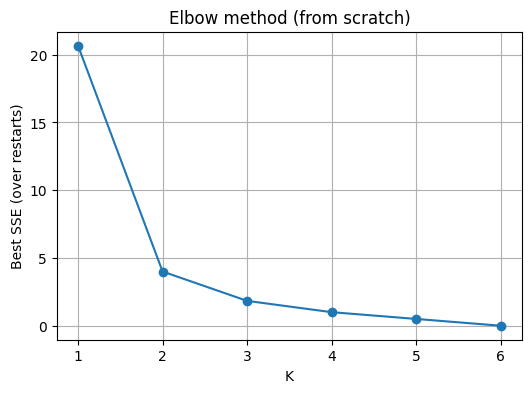

In [17]:
plt.figure(figsize=(6,4))
plt.plot(Ks, best_sse, marker='o')
plt.xlabel('K'); plt.ylabel('Best SSE (over restarts)')
plt.title('Elbow method (from scratch)')
plt.grid(True)
plt.show()


### Elbow rule of thumb
Pick K where adding another cluster gives **much smaller** SSE improvement than before.


## 5) Silhouette score (from scratch)

Silhouette measures both:
- **compactness** (small inside-cluster distances) and
- **separation** (far from other clusters).

For each point i:
- $a(i)$: average distance to points in its own cluster
- $b(i)$: minimum average distance to other clusters

$$s(i)=\frac{b(i)-a(i)}{\max(a(i),b(i))}$$
Average silhouette closer to **1** is better.


In [18]:
def silhouette_numpy(X, labels):
    X = np.asarray(X, float); n = len(X)
    uniq = np.unique(labels); K = len(uniq)
    D = np.sqrt(((X[:,None,:]-X[None,:,:])**2).sum(axis=2))
    s = np.zeros(n, float)
    for i in range(n):
        same = labels == labels[i]
        a = np.mean(D[i, same][D[i, same] != 0]) if np.sum(same) > 1 else 0.0
        b = np.inf
        for k in uniq:
            if k == labels[i]: 
                continue
            other = labels == k
            if np.any(other):
                b = min(b, float(np.mean(D[i, other])))
        s[i] = 0.0 if (b == np.inf or max(a,b) == 0) else (b - a) / max(a, b)
    return float(np.mean(s))


### Silhouette vs K (use best restart solution for each K)

In [19]:
sil_scores = []
for k in range(2,6):
    best, hist, C = best_sse_over_restarts(X2, k, n_init=120)
    sil_scores.append(silhouette_numpy(X2, hist[-1][0]))
sil_scores


[0.5900253427994369,
 0.6018204230834017,
 0.5230954736878245,
 0.8076132705522491]

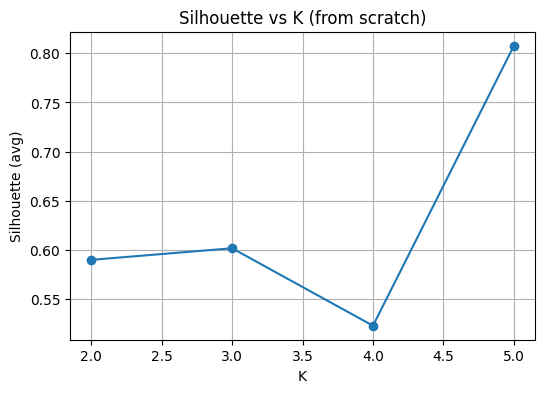

In [20]:
plt.figure(figsize=(6,4))
plt.plot(list(range(2,6)), sil_scores, marker='o')
plt.xlabel('K'); plt.ylabel('Silhouette (avg)')
plt.title('Silhouette vs K (from scratch)')
plt.grid(True)
plt.show()


### Interpreting silhouette
- Higher is better.
- A singleton cluster often yields silhouette ≈ 0 for that point (common in implementations).


## 6) scikit-learn KMeans (validation)

Now we use `sklearn.cluster.KMeans` to confirm results.

If scikit-learn is missing, install it in your environment:
```bash
pip install scikit-learn
```


In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np


### sklearn: fit KMeans for K=2

In [22]:
km2 = KMeans(n_clusters=2, n_init=20, random_state=42)
labels2 = km2.fit_predict(X2)
km2.cluster_centers_


array([[1.        , 1.66666667],
       [3.66666667, 3.66666667]])

### sklearn: SSE (inertia) and silhouette

In [23]:
print('inertia (SSE):', km2.inertia_)
print('silhouette   :', silhouette_score(X2, labels2))
print('labels       :', labels2)


inertia (SSE): 4.0
silhouette   : 0.5900253427994369
labels       : [0 0 0 1 1 1]


### sklearn: elbow + silhouette sweep

In [24]:
Ks = range(1,7)
inert = [KMeans(n_clusters=k, n_init=30, random_state=42).fit(X2).inertia_ for k in Ks]
sil  = [silhouette_score(X2, KMeans(n_clusters=k, n_init=30, random_state=42).fit_predict(X2))
        if (1 < k < len(X2)) else np.nan for k in Ks]

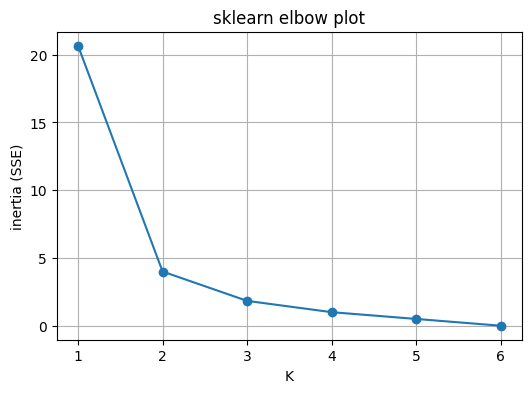

In [25]:
plt.figure(figsize=(6,4))
plt.plot(list(Ks), inert, marker='o')
plt.xlabel('K'); plt.ylabel('inertia (SSE)')
plt.title('sklearn elbow plot')
plt.grid(True)
plt.show()


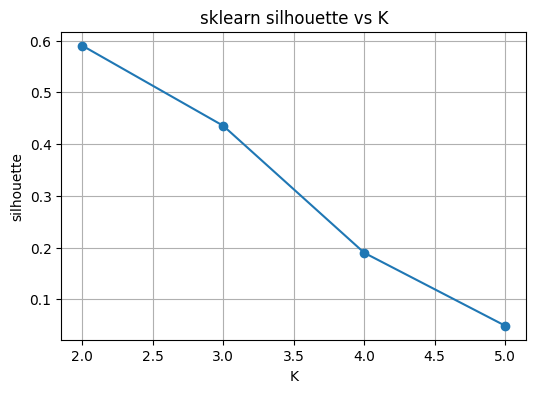

In [26]:
plt.figure(figsize=(6,4))
plt.plot(list(Ks), sil, marker='o')
plt.xlabel('K'); plt.ylabel('silhouette')
plt.title('sklearn silhouette vs K')
plt.grid(True)
plt.show()


## 7) One-slide summary (memorize this)

- **K-Means loop:** initialize → assign → update → repeat until centroids stop moving
- **Objective:** minimize **SSE** (compact clusters)
- **Initialization matters:** can slow convergence or lead to worse local minima
- **Fix init sensitivity:** use **multiple restarts** (`n_init`) or **k-means++**
- **Choose K:**  
  - **Elbow:** where SSE drop slows down  
  - **Silhouette:** higher is better (compact + separated)


# 1. Take larger Set for X - 10 to 15 numbers.
# 2. Take different k values - try 1 to max.
# 3. Take different initial centroids for different K.